In [23]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [57]:
import bs4 as bs
import numpy as np
import pickle
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import requests
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
from collections import Counter
from sklearn import svm, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [40]:
def save_ftse100_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/FTSE_100_Index')
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find('table', {'class':'wikitable sortable', 'id':"constituents"})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        if ticker[-1] == '.':
            tickers.append(ticker + 'L')
        else:
            tickers.append(ticker + '.L')

    with open("ftsetickers.pickle","wb") as f:
        pickle.dump(tickers, f)

    return tickers

In [41]:
tickers = save_ftse100_tickers()

In [42]:
print(tickers)
new_tickers = []
for ticker in tickers:
    new_tickers.append(ticker+'.L')
print(new_tickers)

['III.L', 'ADM.L', 'AAL.L', 'ANTO.L', 'AHT.L', 'ABF.L', 'AZN.L', 'AUTO.L', 'AVST.L', 'AVV.L', 'AV.L', 'BME.L', 'BA.L', 'BARC.L', 'BDEV.L', 'BKG.L', 'BHP.L', 'BP.L', 'BATS.L', 'BLND.L', 'BT-A.L', 'BNZL.L', 'BRBY.L', 'CCH.L', 'CPG.L', 'CRH.L', 'CRDA.L', 'DCC.L', 'DGE.L', 'EVR.L', 'EXPN.L', 'FERG.L', 'FLTR.L', 'FRES.L', 'GSK.L', 'GLEN.L', 'GVC.L', 'HLMA.L', 'HL.L', 'HIK.L', 'HSV.L', 'HSBA.L', 'IMB.L', 'INF.L', 'IHG.L', 'ICP.L', 'IAG.L', 'ITRK.L', 'JD.L', 'JMAT.L', 'JET.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'LSE.L', 'MNG.L', 'MRO.L', 'MNDI.L', 'MRW.L', 'NG.L', 'NWG.L', 'NXT.L', 'OCDO.L', 'PSON.L', 'PNN.L', 'PSN.L', 'PHNX.L', 'POLY.L', 'PRU.L', 'RB.L', 'REL.L', 'RTO.L', 'RIO.L', 'RMV.L', 'RR.L', 'RDSA.L', 'RSA.L', 'SGE.L', 'SBRY.L', 'SDR.L', 'SMT.L', 'SGRO.L', 'SVT.L', 'SN.L', 'SMDS.L', 'SMIN.L', 'SKG.L', 'SPX.L', 'SSE.L', 'STAN.L', 'SLA.L', 'STJ.L', 'TW.L', 'TSCO.L', 'ULVR.L', 'UU.L', 'VOD.L', 'WTB.L', 'WPP.L']
['III.L.L', 'ADM.L.L', 'AAL.L.L', 'ANTO.L.L', 'AHT.L.L', 'ABF.L.L', 'AZN.L

In [43]:
def get_data_from_yahoo(reload_ftse100=False):
    if reload_ftse100:
        tickers = save_ftse100_tickers()
    else:
        with open("ftsetickers.pickle","rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2020,10,14)
    
    for ticker in tickers:
        print("Scraping: "+ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:               
                df = web.DataReader(ticker,'yahoo',start,end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except KeyError:
                pass
        else: 
            print('Already have {}'.format(ticker))

In [44]:
get_data_from_yahoo()

Scraping: III.L
Already have III.L
Scraping: ADM.L
Already have ADM.L
Scraping: AAL.L
Already have AAL.L
Scraping: ANTO.L
Already have ANTO.L
Scraping: AHT.L
Already have AHT.L
Scraping: ABF.L
Already have ABF.L
Scraping: AZN.L
Already have AZN.L
Scraping: AUTO.L
Already have AUTO.L
Scraping: AVST.L
Already have AVST.L
Scraping: AVV.L
Already have AVV.L
Scraping: AV.L
Already have AV.L
Scraping: BME.L
Already have BME.L
Scraping: BA.L
Already have BA.L
Scraping: BARC.L
Already have BARC.L
Scraping: BDEV.L
Already have BDEV.L
Scraping: BKG.L
Already have BKG.L
Scraping: BHP.L
Already have BHP.L
Scraping: BP.L
Already have BP.L
Scraping: BATS.L
Already have BATS.L
Scraping: BLND.L
Already have BLND.L
Scraping: BT-A.L
Already have BT-A.L
Scraping: BNZL.L
Already have BNZL.L
Scraping: BRBY.L
Already have BRBY.L
Scraping: CCH.L
Already have CCH.L
Scraping: CPG.L
Already have CPG.L
Scraping: CRH.L
Already have CRH.L
Scraping: CRDA.L
Already have CRDA.L
Scraping: DCC.L
Already have DCC.L
Scra

In [45]:
def compile_data():
    with open("ftsetickers.pickle", "rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    for count,ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns = {'Adj Close': ticker}, inplace=True)
        df.drop(['Open','High','Low','Close','Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
        
        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('ftse100_joined_closers.csv')

In [46]:
compile_data()

0
10
20
30
40
50
60
70
80
90
            III.L  ADM.L       AAL.L     ANTO.L      AHT.L       ABF.L  \
Date                                                                     
2000-01-03    NaN    NaN  781.102539  28.022253  98.288185  222.255676   
2000-01-04    NaN    NaN  759.270813  28.022253  98.578033  215.279800   
2000-01-05    NaN    NaN  765.914185  28.022253  97.707985  218.686661   
2000-01-06    NaN    NaN  784.709595  28.119221  96.548759  239.452179   
2000-01-07    NaN    NaN  812.422791  28.119221  96.548759  232.313995   

                  AZN.L  AUTO.L  AVST.L      AVV.L  ...      STAN.L  SLA.L  \
Date                                                ...                      
2000-01-03  1155.672729     NaN     NaN  78.619392  ...  381.433258    NaN   
2000-01-04  1104.963013     NaN     NaN  79.714745  ...  370.915070    NaN   
2000-01-05  1082.359009     NaN     NaN  76.672447  ...  356.229218    NaN   
2000-01-06  1080.112915     NaN     NaN  74.238113  ...  332.2

In [10]:
def visualise_data():
    df = pd.read_csv('ftse100_joined_closers.csv')
    df_corr = df.corr()
    
    #print(df_corr.head())
    plt.figure(figsize=(16, 16))
    ax = sns.heatmap(df_corr, linewidth=0.5)
    plt.show()
    data = df_corr.values
    
    

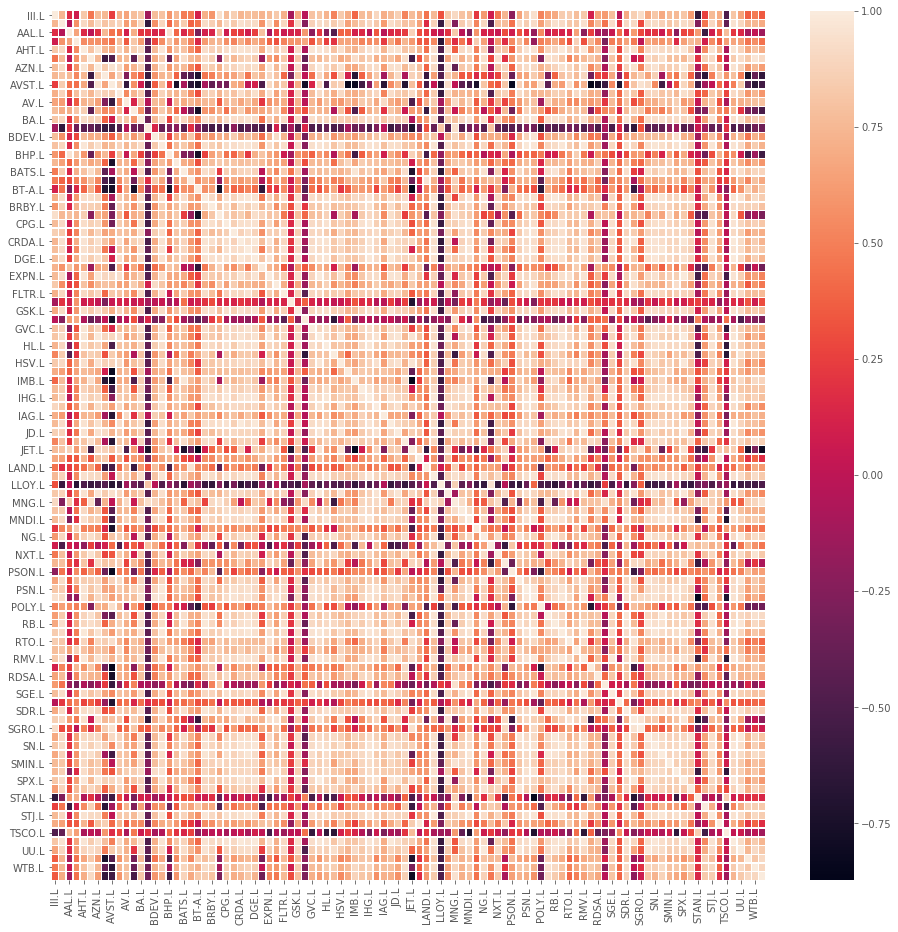

In [11]:
visualise_data()

In [51]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('ftse100_joined_closers.csv')
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1,hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return ticker, df

In [52]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

In [55]:
def extract_featuresets(ticker):
    ticker ,df = process_data_for_labels(ticker)
    hm_days = 7
    df['{}_target'.format(ticker)]= list(map(buy_sell_hold, *[df['{}_{}d'.format(ticker, i)]for i in range(1, hm_days+1)]))
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0,inplace=True)
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X,y,df

In [56]:
extract_featuresets('BA.L')

Data spread:  Counter({'1': 2417, '-1': 2011, '0': 861})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.02794988, ..., -0.03911374,
         -0.02885   ,  0.        ],
        [ 0.        ,  0.        ,  0.00874967, ..., -0.04850813,
         -0.00244326, -0.09793814],
        ...,
        [ 0.00558659,  0.00372578, -0.01045941, ...,  0.00611724,
         -0.03745318, -0.01374778],
        [-0.00925926,  0.00408315,  0.00580308, ...,  0.00143065,
         -0.01729356, -0.00212125],
        [-0.00280374,  0.00665434,  0.00494545, ..., -0.01999998,
         -0.01231852, -0.00728817]]),
 array([-1, -1, -1, ..., -1,  0,  0], dtype=int64),
             Date        III.L   ADM.L        AAL.L       ANTO.L        AHT.L  \
 0     2000-01-03     0.000000     0.0   781.102539    28.022253    98.288185   
 1     2000-01-04     0.000000     0.0   759.270813    28.022253    98.578033   
 2     2000-01-05     0.000000     0.0   765.914185    28.022253    97.707985 

In [64]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    
    #clf = neighbors.KNeighborsClassifier()
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())] )
    
    
    
    clf.fit(X_train, y_train) 
    confidence = clf.score(X_test, y_test)
    print('Accuracy ', confidence)
    
    predictions = clf.predict(X_test)
    print('Predicted Spread: ', Counter(predictions))
    
    return confidence

In [65]:
do_ml('BA.L')

Data spread:  Counter({'1': 2417, '-1': 2011, '0': 861})


G:\Anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy  0.4319213313161876
Predicted Spread:  Counter({1: 932, -1: 388, 0: 2})


0.4319213313161876